## Setup (for colab only)

In [1]:
! git clone https://github.com/theovincent/CPDE.git -b make_ipynb_working

Cloning into 'CPDE'...
remote: Enumerating objects: 350, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (275/275), done.
remote: Total 350 (delta 156), reused 232 (delta 71), pack-reused 0
Receiving objects: 100% (350/350), 6.61 MiB | 15.14 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [1]:
import os 

os.chdir("/content/CPDE")

! pip install -r requirements.txt

In [ ]:
! git pull

## Imports

In [29]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import ruptures as rpt
from SKAB_data.evaluating import evaluating_change_point

%load_ext autoreload
%autoreload 2

from ensemble_methods.aggregations import SCALING_AGGREGATION

SINGLE_COSTS = (
    {'name': 'ar_1', 'cost':'ar', 'params':{'order':1}},
    {'name': 'mahalanobis', 'cost':'mahalanobis', 'params':{}},
    {'name': 'l1', 'cost':'l1', 'params':{}},
    {'name': 'l2', 'cost':'l2', 'params':{}},
    {'name': 'rbf', 'cost': 'rbf', 'params': {}}
)
LIST_COSTS = [dict_cost["cost"] for dict_cost in SINGLE_COSTS]
PARAMS = {"ar": {'order':1}}

DESIRED_ORDER = ["Standart", "LowFP", "LowFN"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [30]:
from sklearn.preprocessing import StandardScaler


# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk("SKAB_data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))


# datasets with anomalies loading
test = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True).drop('anomaly', axis=1) for file in all_files if 'anomaly-free' not in file]

# Save labels
true_cp = [dataset.changepoint for dataset in test]

# Standardise
for idx_data in range(len(test)):
    stsc = StandardScaler()
    test[idx_data] = pd.DataFrame(stsc.fit_transform(test[idx_data].drop("changepoint", axis=1)), columns=test[idx_data].columns.drop("changepoint"), index=test[idx_data].index)

## Visualize a signal

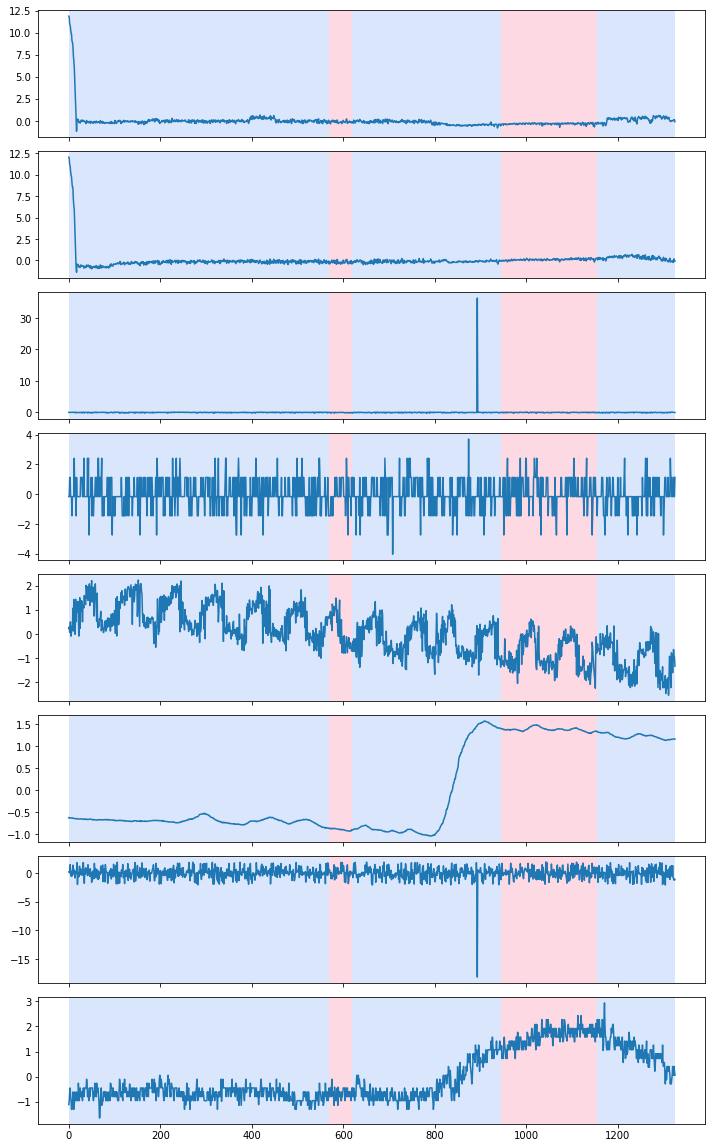

In [31]:
idx_signal = 3

break_points = list(np.nonzero(true_cp[idx_signal].values == 1)[0]) + [test[idx_signal].shape[0]]
_ = rpt.display(test[idx_signal].values, break_points)

## Window search

In [32]:
def window_search(cost, params, **kwargs):
    predicted_cp = []
    for idx_data in range(len(test)):
        algo = rpt.Window(model=cost, 
                          params=params, 
                          width=20,
                          jump=1)
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))
        
        single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

table_costs_window = {}
for cost in tqdm(SINGLE_COSTS):
        table_costs_window[cost["name"]] = window_search(**cost)

pd.DataFrame(table_costs_window).T[DESIRED_ORDER]

  0%|          | 0/5 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
ar_1,15.54,12.77,16.77
mahalanobis,15.55,13.44,16.27
l1,18.40,16.22,19.19
l2,14.78,12.40,16.01
rbf,16.21,13.70,17.22


In [33]:
def window_search_ensemble_bound():
    predicted_cp = []
    for idx_data in tqdm(range(len(test))):
        best_nab_sum = - float("inf")
        best_single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)

        for model in SINGLE_COSTS:
            algo = rpt.Window(model=model["cost"], 
                            params=model["params"], 
                            width=20,
                            jump=1)
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))
            
            single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            
            nab_model = evaluating_change_point([true_cp[idx_data]], [single_predicted_cp], metric='nab', numenta_time='30 sec')
            
            if sum(list(nab_model.values())) > best_nab_sum:
                best_nab_sum = sum(list(nab_model.values()))
                best_single_predicted_cp = single_predicted_cp
                
        predicted_cp.append(best_single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

window_ensemble_bound = window_search_ensemble_bound()
pd.DataFrame(window_ensemble_bound, index=["Ensemble bound"])[DESIRED_ORDER]

  0%|          | 0/34 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
Ensemble bound,29.37,27.79,30.09


In [34]:
from ensemble_methods.window_ensemble import WindowEnsemble

def window_search_ensemble(scale_aggregation):
    predicted_cp = []
    for idx_data in tqdm(range(len(test)), leave=False, position=1):
        algo = WindowEnsemble(
            width=20,
            models=LIST_COSTS,
            params=PARAMS, 
            scale_aggregation=scale_aggregation,
            jump=1
        )
        single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
        
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))

        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

In [35]:
table_ensemble_window = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION.items(), position=0):
    table_ensemble_window[scale_aggregation_name] = window_search_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_window).T[DESIRED_ORDER]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
Min_Raw,15.89,13.47,17.01
Min_MinMax,17.90,15.82,18.60
Min_Znorm,17.41,15.21,18.27
Min_MinAbs,19.61,17.70,20.25
Min_Rank,15.98,13.56,16.80
Sum_Raw,14.85,12.40,15.80
Sum_MinMax,15.98,13.87,16.81
Sum_Znorm,17.04,14.88,17.77
Sum_MinAbs,16.71,14.56,17.55
Sum_Rank,15.10,12.44,16.22


## Dynamic Programming

In [36]:
def dynp_search(cost, params, **kwargs):
    predicted_cp = []
    for idx_data in range(len(test)):
        algo = rpt.Dynp(model=cost, 
                          params=params)
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))
        
        single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

table_costs_dynp = {}
for cost in tqdm(SINGLE_COSTS):
    table_costs_dynp[cost["name"]] = dynp_search(**cost)

pd.DataFrame(table_costs_dynp).T[DESIRED_ORDER]

  0%|          | 0/5 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
ar_1,19.40,16.83,20.63
mahalanobis,22.37,19.90,23.37
l1,18.64,15.99,20.12
l2,18.96,16.50,20.33
rbf,19.33,16.67,20.83


In [37]:
def dynp_search_ensemble_bound():
    predicted_cp = []
    for idx_data in tqdm(range(len(test))):
        best_nab_sum = - float("inf")
        best_single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)

        for model in SINGLE_COSTS:
            algo = rpt.Dynp(model=model["cost"], 
                          params=model["params"],)
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))
            
            single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            
            nab_model = evaluating_change_point([true_cp[idx_data]], [single_predicted_cp], metric='nab', numenta_time='30 sec')
            
            if sum(list(nab_model.values())) > best_nab_sum:
                best_nab_sum = sum(list(nab_model.values()))
                best_single_predicted_cp = single_predicted_cp
                
        predicted_cp.append(best_single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

dynp_ensemble_bound = dynp_search_ensemble_bound()
pd.DataFrame(dynp_ensemble_bound, index=["Ensemble bound"])[DESIRED_ORDER]

  0%|          | 0/34 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
Ensemble bound,28.34,26.0,29.66


In [38]:
from ensemble_methods.dynamic_programming_ensemble import DynpEnsemble

def dynamique_programming_ensemble(scale_aggregation):
    predicted_cp = []
    for idx_data in tqdm(range(len(test)), leave=False, position=1):
        algo = DynpEnsemble(
            models=LIST_COSTS,
            params=PARAMS, 
            scale_aggregation=scale_aggregation,
        )
        single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
        
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))

        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

In [39]:
table_ensemble_dynp = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION.items(), position=0):
    table_ensemble_dynp[scale_aggregation_name] = dynamique_programming_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_dynp).T[DESIRED_ORDER]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
Min_Raw,19.33,16.67,20.83
Min_MinMax,16.43,14.02,17.36
Min_Znorm,19.71,17.32,20.83
Min_MinAbs,19.33,16.67,20.83
Min_Rank,19.23,16.29,20.51
Sum_Raw,19.86,17.56,20.93
Sum_MinMax,19.40,17.02,20.63
Sum_Znorm,20.94,18.56,22.17
Sum_MinAbs,19.90,17.64,20.96
Sum_Rank,21.62,19.15,22.87


## Binary Segmentation

In [40]:
def binseg_search(cost, params, **kwargs):
    predicted_cp = []
    for idx_data in range(len(test)):
        algo = rpt.Binseg(model=cost, 
                          params=params)
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))
        
        single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

table_costs_dynp = {}
for cost in tqdm(SINGLE_COSTS):
    table_costs_dynp[cost["name"]] = binseg_search(**cost)

pd.DataFrame(table_costs_dynp).T[DESIRED_ORDER]

  0%|          | 0/5 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
ar_1,21.39,18.89,22.72
mahalanobis,24.10,21.69,25.04
l1,17.87,15.10,19.09
l2,17.46,14.81,18.82
rbf,20.86,18.20,22.37


In [41]:
def binseg_search_ensemble_bound():
    predicted_cp = []
    for idx_data in tqdm(range(len(test))):
        best_nab_sum = - float("inf")
        best_single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)

        for model in SINGLE_COSTS:
            algo = rpt.Binseg(model=model["cost"], 
                          params=model["params"])
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))
            
            single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            
            nab_model = evaluating_change_point([true_cp[idx_data]], [single_predicted_cp], metric='nab', numenta_time='30 sec')
            
            if sum(list(nab_model.values())) > best_nab_sum:
                best_nab_sum = sum(list(nab_model.values()))
                best_single_predicted_cp = single_predicted_cp
                
        predicted_cp.append(best_single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

binseg_ensemble_bound = binseg_search_ensemble_bound()
pd.DataFrame(binseg_ensemble_bound, index=["Ensemble bound"])[DESIRED_ORDER]

  0%|          | 0/34 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
Ensemble bound,30.35,27.91,31.77


In [42]:
from ensemble_methods.binary_segmentation_ensemble import BinsegEnsemble

def binary_segmentation_ensemble(scale_aggregation):
    predicted_cp = []
    for idx_data in tqdm(range(len(test)), leave=False, position=1):
        algo = BinsegEnsemble(
            models=LIST_COSTS,
            params=PARAMS, 
            scale_aggregation=scale_aggregation
        )
        single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
        
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))

        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

In [43]:
table_ensemble_dynp = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION.items(), position=0):
    table_ensemble_dynp[scale_aggregation_name] = binary_segmentation_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_dynp).T[DESIRED_ORDER]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

IndexError: ignored